# Ahkab is a SPICE-like python package written by Giuseppe Venturini, Ian Daniher, Rob Crowther

In [1]:
AHKAB_PATH = "/Users/nikolas/src/ahkab"
import sys
if not AHKAB_PATH in sys.path: sys.path.append(AHKAB_PATH)

In [1]:
import ahkab

# Example copied from Ahkab's readme file

AttributeError: module 'pylab' has no attribute 'hold'

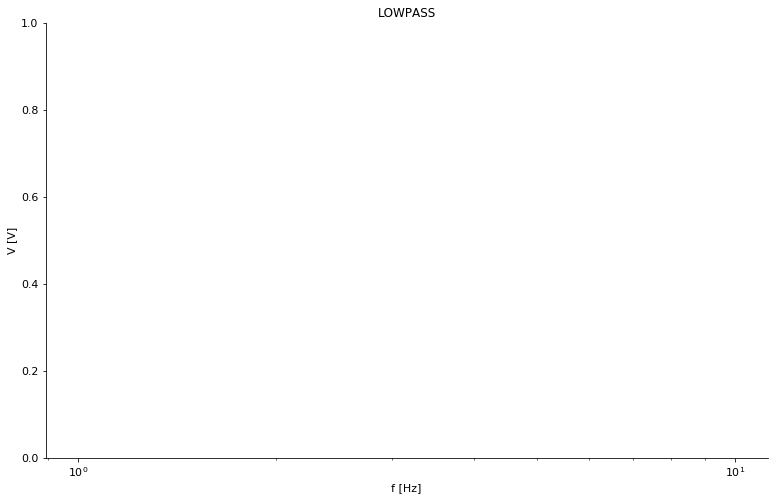

In [1]:
from ahkab import new_ac, run
from ahkab.circuit import Circuit
from ahkab.plotting import plot_results # calls matplotlib for you
import numpy as np

# Define the circuit
cir = Circuit('lowpass filter')
cir.add_vsource('V1', 'n1', cir.gnd, dc_value=0., ac_value=1.)
cir.add_resistor('R1', 'n1', 'n2', 1)
cir.add_capacitor('C1', 'n2', cir.gnd, 1)


# Define the analysis
ac1 = new_ac(2.*np.pi*1e-2, 2.*np.pi*1e1, 100, x0=None)

# run it
res = run(cir, ac1)

# plot the results
plot_results('Lowpass', [('|Vn2|',"")], res['ac'],
             outfilename='lowpass.png')

In [2]:
import cirq; cirq.init_js()

ImportError: No module named 'cirq'

In [74]:
net = cirq.Domain(name="net", causal=False)
n = cirq.Port(name="n", domain=net, direction="inout")
p = cirq.Port(name="p", domain=net, direction="inout")
vsource = cirq.ComponentType(name="VoltageSource", 
                             ports=cirq.clone_ports([p, n]), 
                             parameters=["dc_value", "ac_value"])
resistor = cirq.ComponentType(name="Resistor",
                              ports = cirq.clone_ports([p, n]),
                              parameters=["value"])
capacitor = cirq.ComponentType(name="Capacitor",
                              ports = cirq.clone_ports([p, n]),
                              parameters=["value"])

## Start building circuit with cirq

In [75]:
lowpass = cirq.CircuitBuilder([net], [vsource, resistor, capacitor], cirq.Circuit(name="LowPass"))
lowpass

## Customization of component symbol

In [106]:
lowpass.circuit.c.R1._inner_svg ="""
<path 
    d="M 0 -40 l 0 10 l -5 5 
        l 10 10 l -10 10 l 10 10 l -10 10 l 10 10 
        l -5 5 L 0 40" 
    stroke="black"
    stroke-width="2px"
    fill="none"/>
"""
lowpass.circuit.c.R1._x_label=20
lowpass.circuit.c.R1._label_color = "black"



lowpass.circuit.c.R1.p.p._x = 0
lowpass.circuit.c.R1.p.p._y = 40
lowpass.circuit.c.R1.p.p._phi = pi/2.


lowpass.circuit.c.R1.p.n._x = 0
lowpass.circuit.c.R1.p.n._y = -40
lowpass.circuit.c.R1.p.n._phi = -pi/2.



In [107]:
# reset 
lowpass.circuit.c.R1._inner_svg = ""
lowpass.circuit.c.R1._x_label=0
lowpass.circuit.c.R1._label_color = "white"
lowpass.circuit.c.R1.layout_ports(lowpass.circuit.c.R1.ports)

## General code to translate all circuit involving voltage sources, resistors and capacitors

In [105]:
def translate_to_ahkab(circuit):
    """
    Convert a cirq Circuit representation into an ahkab model.
    """
    
    
    ret = Circuit(circuit.name.encode("ascii", "ignore"))

    # find groups/cliques of connected ports, treat GND specially
    nets = {circuit.p.GND: (0, set([circuit.p.GND]))}
    # each entry of nets has as the key the overall port within the circuit
    # and as value a tuple of a number identifying the clique/group 
    # and a set containing all other members
    
    
    nk = 1
    nets_by_nk = {}
    
    # add other external ports
    for p in circuit.ports:
        if p.name == "GND":
            continue
        nets[p] = (nk, set([p]))
        nk += 1

    # add internal ports
    for c in circuit.component_instances:
        for p in c.ports:
            nets[p] = (nk, set([p]))
            nk +=1

    # resolve connections
    for c in circuit.connections:
        # source and target are of same clique, so combine them
        s, t = c.source, c.target
        (ns, pss), (nt, pts) = nets[s], nets[t]
        
        mn = min(ns, nt)
        ma = max(ns, nt)
        clique = pss | pts
        for pp in clique:
            # for all members of the clique, 
            # set the net index to the lowest possible index
            # store all members of the clique
            nets[pp] = mn, clique
            
        nets_by_nk[mn] = clique
        if ns != nt and ma in nets_by_nk:
            del nets_by_nk[ma]
            
    # extend this to allow for more components!        
    methods = {
                vsource: ret.add_vsource,
                resistor: ret.add_resistor,
                capacitor: ret.add_capacitor
            }
    
    # find which nets are connected to non-GND external ports
    ext = {p: "n{}".format(nets[p][0]) for p in circuit.ports if p is not circuit.p.GND}
    
    # create ahkab object
    for c in circuit.component_instances:
        nn = []
        for p in c.ports:
            if nets[p][0] == 0: # connected to gnd
                nn.append(ret.gnd)
            else:
                nn.append("n{}".format(nets[p][0]))
        methods[c.ctype](c.name.encode("ascii", "ignore"), nn[0], nn[1], **c.param_assignments)

    return ret, ext, nets_by_nk
                
    

## Recompute transfer function for cirq circuit

In [77]:
def analyze(RR = 1., CC = 1.):
    lowpass.circuit.c.R1.param_assignments = dict(value=RR)
    lowpass.circuit.c.C1.param_assignments = dict(value=CC)
    lowpass.circuit.c.V1.param_assignments = dict(dc_value=0., ac_value=1)
    cir2, ext, nets = translate_to_ahkab(lowpass.circuit)
    # Define the analysis
    ac1 = new_ac(2.*np.pi*1e-2, 2.*np.pi*1e1, 100, x0=None)

    # run it
    res2 = run(cir2, ac1)

    OUT_index = '|V{}|'.format(ext[lowpass.circuit.p.OUT]).encode("ascii", "ignore")

    # plot the results
    plot_results('Lowpass', [(OUT_index,"")], res2['ac'],
                 outfilename='lowpass.png')


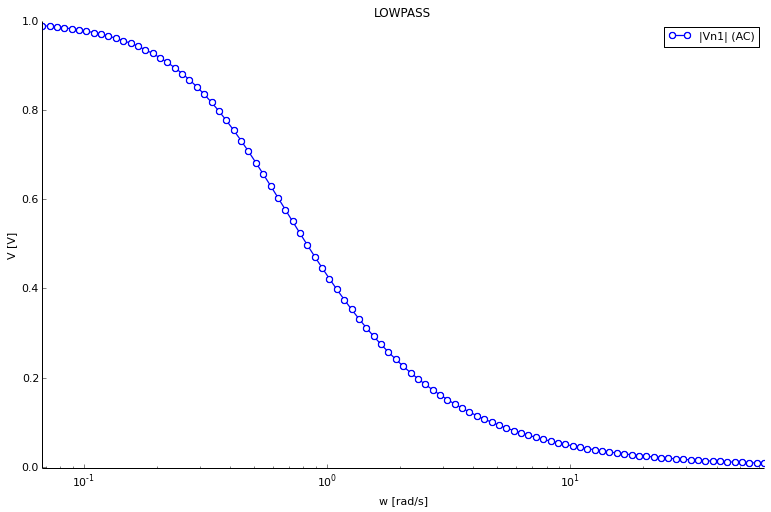

In [78]:
from IPython.html.widgets import interact
interact(analyze,
         RR = (.5, 1.5, .1), 
         CC = (.5, 1.5, .1))